In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

sns.set_style("whitegrid")

In [3]:
df1 = pd.read_csv('data_01.csv')
df2 = pd.read_csv('data_02.csv')
df3 = pd.read_csv('data_03.csv')
df4 = pd.read_csv('data_04.csv')
df5 = pd.read_csv('data_05.csv')

df5

,x,y
0,18.314043,12.567804
1,11.975118,6.350926
2,20.188111,11.388653
3,15.787947,10.970399
4,9.641064,6.453270
5,9.763732,5.259726
6,21.278046,13.825541
7,13.725025,8.986913
8,22.607104,14.651106
9,19.547665,13.347023


In [5]:
df6 = pd.read_csv('data_06.csv')

In [6]:
# так как данные разной размерности, будем выкидывать выбросы из тех данных, в которых больше точек в 1,2,3,4 (методом подгонометрии :) )
# q_low = df1.x.quantile(0.01)
# q_hi  = df1.x.quantile(0.99)

# df1 = df1[(df1.x < q_hi) & (df1.x > q_low)]
# df1 = df1.reset_index(drop = True)
print(df1.shape)
####

# q_low = df2.x.quantile(0.01)
# q_hi  = df2.x.quantile(0.99)

# df2 = df2[(df2.x < q_hi) & (df2.x > q_low)]
# df2 = df2.reset_index(drop = True)
print(df2.shape)

####

# q_low = df3.x.quantile(0.01)
# q_hi  = df3.x.quantile(0.99)

# df3 = df3[(df3.x < q_hi) & (df3.x > q_low)]
# df3 = df3.reset_index(drop = True)
print(df3.shape)
###

# q_low = df4.x.quantile(0.01)
# q_hi  = df4.x.quantile(0.99)

# df4 = df4[(df4.x < q_hi) & (df4.x > q_low)]
# df4 = df4.reset_index(drop = True)
print(df4.shape)

(55, 2)
(50, 2)
(55, 2)
(53, 2)


In [7]:
# q_low = df5.x.quantile(0.01)
# q_hi  = df5.x.quantile(0.99)

# df5 = df5[(df5.x < q_hi) & (df5.x > q_low)]
# df = df5.reset_index(drop = True)x
print(df5.shape)

(47, 2)


In [8]:
df = pd.concat([df1, df2[0:47], df3, df4, df5, df6], axis=0).dropna() #довырезаем из 2 рандомную точку (да, плохо, но выдумывать ракету некогда)
df

,x,y
0,13.344351,9.064982
1,12.141748,9.742935
2,16.045178,10.697097
3,9.044173,7.119905
4,16.597604,11.721995
...,...,...
44,16.883676,11.708367
45,13.678907,8.130473
46,14.441869,10.134124
0,13.252132,8.762344


In [9]:
N = 47
M = 6
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 5)
idx = np.append(idx, 5)
np.random.seed(42)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = df.y
x_m = df.x
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

_, ax = plt.subplots(2, 3, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
    j += N
    k += N
plt.tight_layout()

ValueError: operands could not be broadcast together with shapes (237,) (259,) 

In [12]:
x_centered = x_m - x_m.mean()

with pm.Model() as unpooled_model:
    α_tmp = pm.Normal('α_tmp', mu=0, sigma=10, shape=M)
    β = pm.Normal('β', mu=0, sigma=10, shape=M)
    ε = pm.HalfCauchy('ε', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sigma=ε, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean())

    trace_up = pm.sample(2000)
az.plot_forest(trace_up, var_names=['α', 'β'], combined=True);

/Users/imachome/anaconda3/lib/python3.11/site-packages/pytensor/tensor/rewriting/shape.py:157: UserWarning: Failed to infer_shape from Op Mul.
Input shapes: [(TensorConstant(TensorType(int64, shape=()), data=array(237)),), (TensorConstant(TensorType(int64, shape=()), data=array(259)),)]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Could not broadcast dimensions. Incompatible shapes were [(TensorConstant(TensorType(int64, shape=()), data=array(237)),), (TensorConstant(TensorType(int64, shape=()), data=array(259)),)].
Traceback: Traceback (most recent call last):
  File "/Users/imachome/anaconda3/lib/python3.11/site-packages/pytensor/tensor/rewriting/shape.py", line 133, in get_node_infer_shape
    o_shapes = shape_infer(
               ^^^^^^^^^^^^
  File "/Users/imachome/anaconda3/lib/python3.11/site-packages/pytensor/tensor/elemwise.py", line 837, in infer_shape
    out_shape = broadcast_shape(*i_shapes, arrays_are_shapes=True)
                ^^^^

/Users/imachome/anaconda3/lib/python3.11/site-packages/pytensor/tensor/rewriting/shape.py:157: UserWarning: Failed to infer_shape from Op Composite{...}.
Input shapes: [(TensorConstant(TensorType(int64, shape=()), data=array(237)),), (TensorConstant(TensorType(int64, shape=()), data=array(259)),), (TensorConstant(TensorType(int64, shape=()), data=array(237)),), (TensorConstant(TensorType(int64, shape=()), data=array(259)),), (TensorConstant(TensorType(int64, shape=()), data=array(1)),), (TensorConstant(TensorType(int64, shape=()), data=array(1)),), (TensorConstant(TensorType(int64, shape=()), data=array(1)),), (TensorConstant(TensorType(int64, shape=()), data=array(1)),), (TensorConstant(TensorType(int64, shape=()), data=array(1)),), (TensorConstant(TensorType(int64, shape=()), data=array(1)),), (TensorConstant(TensorType(int64, shape=()), data=array(1)),), (TensorConstant(TensorType(int64, shape=()), data=array(1)),), (TensorConstant(TensorType(int64, shape=()), data=array(1)),), (Ten

/Users/imachome/anaconda3/lib/python3.11/site-packages/pytensor/tensor/rewriting/shape.py:157: UserWarning: Failed to infer_shape from Op Composite{switch(i9, (i8 - (i6 * i7 * log1p(((i4 * sqr((i3 - (i2 + (i0 * i1))))) / i5)))), i10)}.
Input shapes: [(TensorConstant(TensorType(int64, shape=()), data=array(237)),), (TensorConstant(TensorType(int64, shape=()), data=array(259)),), (TensorConstant(TensorType(int64, shape=()), data=array(237)),), (TensorConstant(TensorType(int64, shape=()), data=array(259)),), (TensorConstant(TensorType(int64, shape=()), data=array(1)),), (TensorConstant(TensorType(int64, shape=()), data=array(1)),), (TensorConstant(TensorType(int64, shape=()), data=array(1)),), (TensorConstant(TensorType(int64, shape=()), data=array(1)),), (TensorConstant(TensorType(int64, shape=()), data=array(1)),), (TensorConstant(TensorType(int64, shape=()), data=array(1)),), (TensorConstant(TensorType(int64, shape=()), data=array(1)),)]
Exception encountered during infer_shape: <class

ValueError: Input dimension mismatch: (input[0].shape[0] = 237, input[1].shape[0] = 259)
Apply node that caused the error: Composite{switch(i8, (i7 - (0.5 * i6 * log1p(((i4 * sqr((i3 - (i2 + (i0 * i1))))) / i5)))), -inf)}(AdvancedSubtensor1.0, [-1.702839 ... 85513e+00], AdvancedSubtensor1.0, y_pred{[ 9.064981 ... .43994714]}, ExpandDims{axis=0}.0, ExpandDims{axis=0}.0, Composite{...}.1, Composite{...}.0, ExpandDims{axis=0}.0)
Toposort index: 16
Inputs types: [TensorType(float64, shape=(None,)), TensorType(float64, shape=(259,)), TensorType(float64, shape=(None,)), TensorType(float64, shape=(259,)), TensorType(float64, shape=(1,)), TensorType(float64, shape=(1,)), TensorType(float64, shape=(1,)), TensorType(float64, shape=(1,)), TensorType(bool, shape=(1,))]
Inputs shapes: [(237,), (259,), (237,), (259,), (1,), (1,), (1,), (1,), (1,)]
Inputs strides: [(8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (1,)]
Inputs values: ['not shown', 'not shown', 'not shown', 'not shown', array([0.00768707]), array([44.18783593]), array([45.18783593]), array([-3.3587036]), array([ True])]
Outputs clients: [[Sum{axes=None}(lam > 0, nu > 0)]]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [ ]:
with pm.Model() as hierarchical_model:
    # априорные гипер-распределения
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sigma=10)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', sigma=10)
    β_μ = pm.Normal('β_μ', mu=0, sigma=1)
    β_σ = pm.HalfNormal('β_σ', sigma=1)

    # априорные распеределения
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sigma=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sigma=β_σ, shape=M)
    ε = pm.HalfCauchy('ε', 5)
    ν = pm.Exponential('ν', 1/30)

    # апосториорное распределение
    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sigma=ε, nu=ν, observed=y_m)

    # обратное перемасштабирование
    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x_m.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())

    # трассировка
    trace_hm = pm.sample(3000,tune = 1000) #target_accept=.8

az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True);

In [10]:
az.plot_forest(trace_hm, var_names=['α', 'β'],kind ='ridgeplot',
               combined=True,
               ridgeplot_truncate=False,
               ridgeplot_quantiles=[.25, .5, .75],
               ridgeplot_overlap=0.7,
               colors='white');

NameError: name 'trace_hm' is not defined

NameError: name 'trace_hm' is not defined

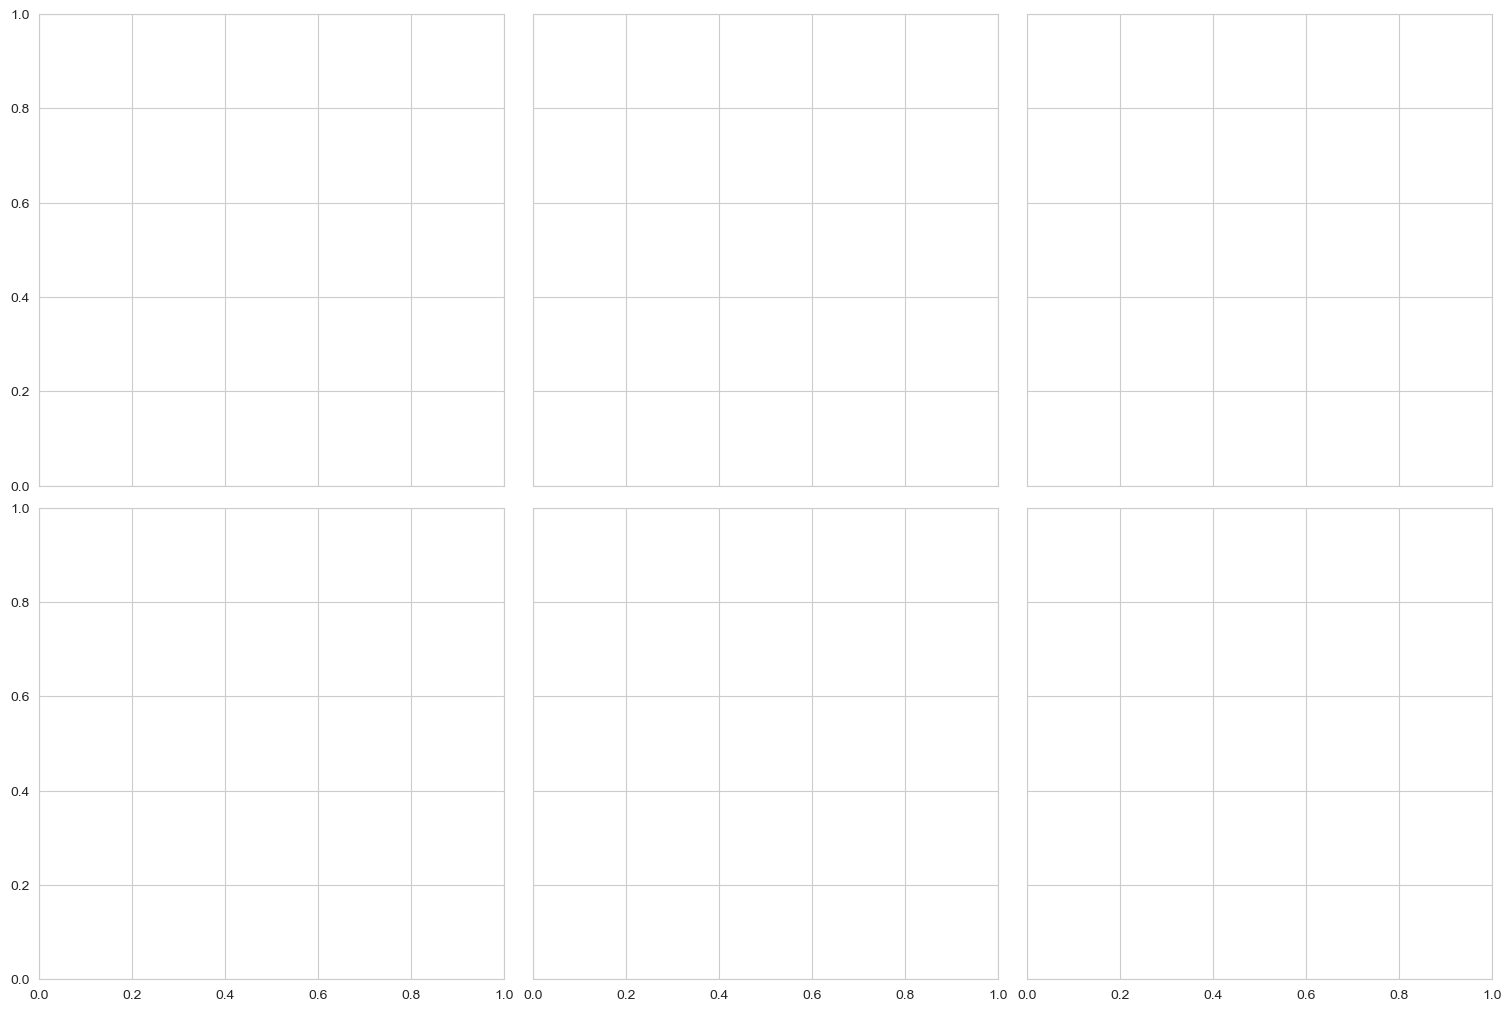

In [11]:
_, ax = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True,
                     constrained_layout=True)

trace_hmm = trace_hm.posterior.stack(samples={"chain", "draw"})
trace_upp = trace_up.posterior.stack(samples={"chain", "draw"})


ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)

for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = trace_hmm['α'].sel({'α_dim_0':i}).mean().item()
    beta_m  = trace_hmm['β'].sel({'β_dim_0':i}).mean().item()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='r',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x'+' - иерахич. модель')

    # alpha_o = trace_upp['α'].sel({'α_dim_0':i}).mean().item()
    # beta_o = trace_upp['β'].sel({'β_dim_0':i}).mean().item()
    # ax[i].plot(x_range, alpha_o + beta_o * x_range, 'g--',
    #            label=f'y = {alpha_o:.2f} + {beta_o:.2f} * x'+' - неиерахич. модель')

    ax[i].legend()
    # plt.xlim(x_m.min()-1, x_m.max()+1)
    # plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N
